<a href="https://colab.research.google.com/github/krymbeaulieu/cmpe258-group3-style-transfer/blob/main/CMPE_258_Project_G3_Lee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install lpips

In [57]:
import os
import zipfile
import glob, random
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
import lpips
import torch.optim as optim

In [3]:
WIKIART_PATH = "/content/drive/MyDrive/CMPE258/project/archive"
COCO_PATH = "/content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017"

print("WikiArt:", os.path.exists(WIKIART_PATH))
print("COCO:", os.path.exists(COCO_PATH))


WikiArt: True
COCO: True


In [7]:
coco_images = glob.glob(f"{COCO_PATH}/*.jpg")
print("Found", len(coco_images), "COCO images")

wikiart_images = glob.glob(f"{WIKIART_PATH}/**/*.jpg", recursive=True)
print("Found", len(wikiart_images), "WikiArt images")

# content_img = random.choice(coco_images)
# style_img = random.choice(wikiart_images)

# print("Content image:", content_img)
# print("Style image:", style_img)


Found 123404 COCO images
Found 81444 WikiArt images


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_size = 512

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

def load_image(path):
    image = Image.open(path).convert("RGB")
    return transform(image).unsqueeze(0).to(device)

def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")


In [9]:
vgg = models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1').features.to(device).eval()

# Extract intermediate layers for content & style
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 244MB/s]


In [10]:
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G / (c * h * w)

In [24]:
def style_transfer(content, style, model, content_weight=1, style_weight=1e6, steps=5000, stop_threshold=10000):

    target = content.clone().requires_grad_(True).to(device) # Target Image
    optimizer = torch.optim.Adam([target], lr=0.005)

    for i in range(steps):
        target_features = get_features(target, model)
        content_features = get_features(content, model)
        style_features = get_features(style, model)

        # Content loss (MSE)
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

        # Style loss
        style_loss = 0
        for layer in ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']:
            target_f = target_features[layer]
            style_f = style_features[layer]
            _, c, h, w = target_f.shape
            target_gram = torch.mm(target_f.view(c, h * w), target_f.view(c, h * w).t())
            style_gram = torch.mm(style_f.view(c, h * w), style_f.view(c, h * w).t())
            layer_style_loss = torch.mean((target_gram - style_gram)**2) / (c * h * w)
            style_loss += layer_style_loss

        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        with torch.no_grad():
            target.clamp_(0, 1)

        if i % 100 == 0:
            print(f"Step [{i}/{steps}]  Total Loss: {total_loss.item():.2f}")

        if total_loss.item() < stop_threshold:
            print(f"Stopping early at step {i}, total loss = {total_loss.item():.2f}")
            break

    return target


In [46]:
# Initialize once (so we don’t reload model each time)
lpips_model = lpips.LPIPS(net='vgg').to(device)
lpips_model.eval()

def get_lpips(img1, img2):
    """
    Compute LPIPS (Learned Perceptual Image Patch Similarity) distance
    between two images using a pretrained VGG network.

    Args:
        img1 (torch.Tensor): First image tensor [1, 3, H, W], normalized to [0,1].
        img2 (torch.Tensor): Second image tensor [1, 3, H, W], normalized to [0,1].

    Returns:
        float: LPIPS distance (lower = more perceptually similar)
    """
    with torch.no_grad():
        dist = lpips_model(img1, img2)
    return dist.item()


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 239MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000160675.jpg


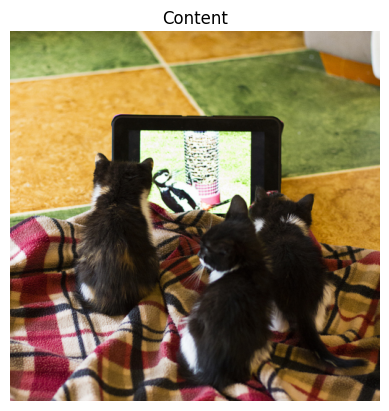

In [26]:
content_img = f"{COCO_PATH}/000000160675.jpg"
# content_img = random.choice(coco_images)

content = load_image(content_img)
imshow(content, "Content")
print("Content image:", content_img)


Style image: /content/drive/MyDrive/CMPE258/project/archive/Post_Impressionism/constantine-maleas_olympia.jpg


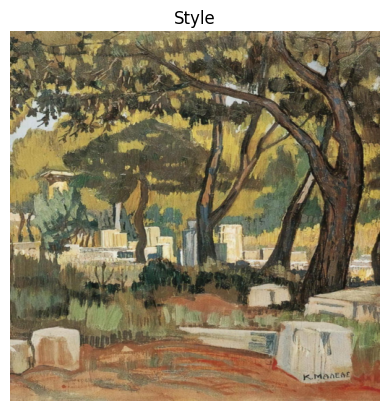

In [27]:
style_img= f"{WIKIART_PATH}/Post_Impressionism/constantine-maleas_olympia.jpg"
# style_img = random.choice(wikiart_images)
style = load_image(style_img)
imshow(style, "Style")
print("Style image:", style_img)


Step [0/5000]  Total Loss: 11066583.00
Step [100/5000]  Total Loss: 359914.28
Step [200/5000]  Total Loss: 200927.05
Step [300/5000]  Total Loss: 140852.77
Step [400/5000]  Total Loss: 107067.68
Step [500/5000]  Total Loss: 85599.18
Step [600/5000]  Total Loss: 71108.69
Step [700/5000]  Total Loss: 60945.52
Step [800/5000]  Total Loss: 53585.04
Step [900/5000]  Total Loss: 48053.73
Step [1000/5000]  Total Loss: 43768.68
Step [1100/5000]  Total Loss: 40339.76
Step [1200/5000]  Total Loss: 37521.54
Step [1300/5000]  Total Loss: 35147.76
Step [1400/5000]  Total Loss: 33117.39
Step [1500/5000]  Total Loss: 31342.44
Step [1600/5000]  Total Loss: 29780.92
Step [1700/5000]  Total Loss: 28395.30
Step [1800/5000]  Total Loss: 27151.81
Step [1900/5000]  Total Loss: 26019.19
Step [2000/5000]  Total Loss: 24987.35
Step [2100/5000]  Total Loss: 24040.72
Step [2200/5000]  Total Loss: 23169.90
Step [2300/5000]  Total Loss: 22363.37
Step [2400/5000]  Total Loss: 21613.68
Step [2500/5000]  Total Loss: 

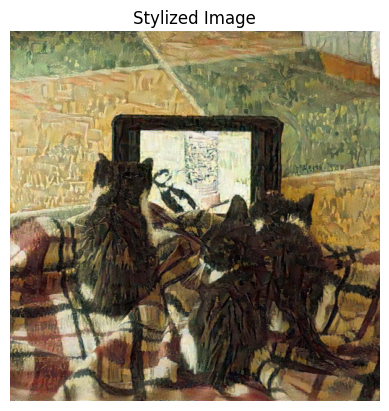

In [28]:
output = style_transfer(content, style, vgg, steps=5000, stop_threshold=10000)
imshow(output, "Stylized Image")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.3 MB/s eta 0:00:00


In [ ]:
# Initialize LPIPS model
lpips_model = lpips.LPIPS(net='vgg').to(device)

# Compute perceptual distance between content and stylized output
lpips_distance = lpips_model(content, output)
print(f"LPIPS (content-output): {lpips_distance.item():.4f}")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth
LPIPS (content-output): 0.5250


Post-Impressionism

In [47]:
get_lpips(content1, impressionism_output)

0.5871378183364868

Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000115526.jpg


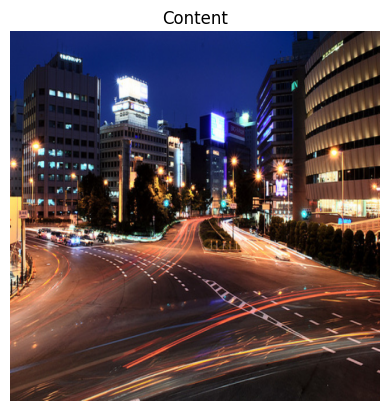

In [22]:
content_img1 = f"{COCO_PATH}/000000115526.jpg"
content1 = load_image(content_img1)
imshow(content1, "Content")
print("Content image:", content_img1)


Style image: /content/drive/MyDrive/CMPE258/project/archive/Post_Impressionism/vincent-van-gogh_the-starry-night-1889(1).jpg


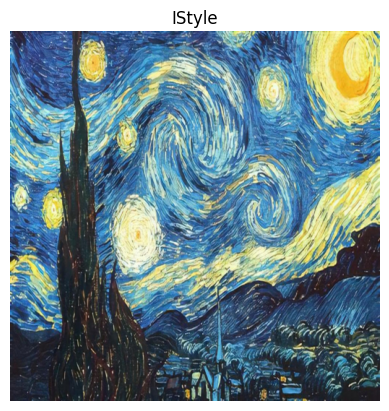

In [21]:
imp_style_img= f"{WIKIART_PATH}/Post_Impressionism/vincent-van-gogh_the-starry-night-1889(1).jpg"
imp_style = load_image(imp_style_img)
imshow(imp_style, "IStyle")
print("Style image:", imp_style_img)


Step [0/5000]  Total Loss: 52265620.00
Step [100/5000]  Total Loss: 4408358.00
Step [200/5000]  Total Loss: 2447546.25
Step [300/5000]  Total Loss: 1616837.88
Step [400/5000]  Total Loss: 1170119.62
Step [500/5000]  Total Loss: 905955.62
Step [600/5000]  Total Loss: 733263.62
Step [700/5000]  Total Loss: 609083.38
Step [800/5000]  Total Loss: 513596.59
Step [900/5000]  Total Loss: 437055.22
Step [1000/5000]  Total Loss: 374261.72
Step [1100/5000]  Total Loss: 321947.72
Step [1200/5000]  Total Loss: 278161.22
Step [1300/5000]  Total Loss: 241447.23
Step [1400/5000]  Total Loss: 210785.48
Step [1500/5000]  Total Loss: 185215.81
Step [1600/5000]  Total Loss: 163990.80
Step [1700/5000]  Total Loss: 146464.73
Step [1800/5000]  Total Loss: 131985.34
Step [1900/5000]  Total Loss: 120042.02
Step [2000/5000]  Total Loss: 110187.42
Step [2100/5000]  Total Loss: 102031.15
Step [2200/5000]  Total Loss: 95239.48
Step [2300/5000]  Total Loss: 89538.91
Step [2400/5000]  Total Loss: 84703.59
Step [250

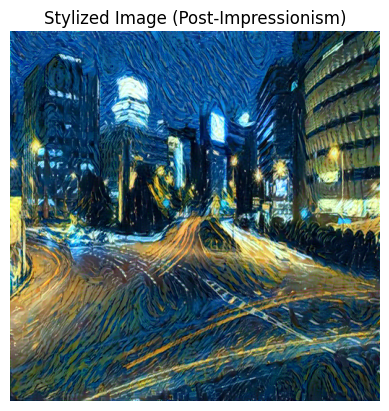

In [53]:
impressionism_output = style_transfer(content1, imp_style, vgg, steps=5000, stop_threshold=1000)
imshow(impressionism_output, "Stylized Image (Post-Impressionism)")

Fauvism Style image: /content/drive/MyDrive/CMPE258/project/archive/Fauvism/andre-derain_charing-cross-bridge.jpg


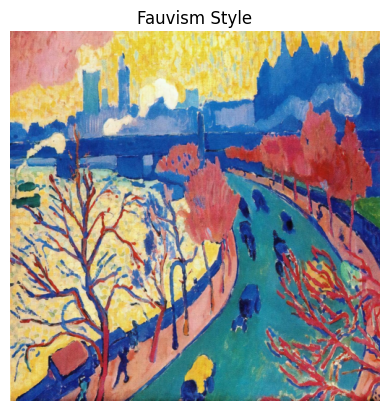

In [42]:
fauvism_style_img= f"{WIKIART_PATH}/Fauvism/andre-derain_charing-cross-bridge.jpg"
fauvism_style = load_image(fauvism_style_img)
imshow(fauvism_style, "Fauvism Style")
print("Fauvism Style image:", fauvism_style_img)



Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000469239.jpg


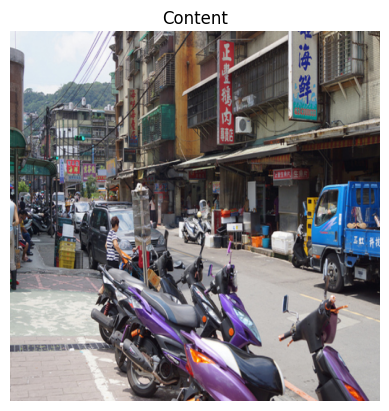

In [43]:
content_img2 = f"{COCO_PATH}/000000469239.jpg"
content2 = load_image(content_img2)
imshow(content2, "Content")
print("Content image:", content_img2)



Step [0/5000]  Total Loss: 37324464.00
Step [100/5000]  Total Loss: 2805791.75
Step [200/5000]  Total Loss: 1437055.62
Step [300/5000]  Total Loss: 1032867.44
Step [400/5000]  Total Loss: 832978.38
Step [500/5000]  Total Loss: 709561.50
Step [600/5000]  Total Loss: 623545.88
Step [700/5000]  Total Loss: 558577.81
Step [800/5000]  Total Loss: 506885.44
Step [900/5000]  Total Loss: 464162.69
Step [1000/5000]  Total Loss: 427784.97
Step [1100/5000]  Total Loss: 396099.97
Step [1200/5000]  Total Loss: 368150.59
Step [1300/5000]  Total Loss: 343303.84
Step [1400/5000]  Total Loss: 320989.91
Step [1500/5000]  Total Loss: 300683.56
Step [1600/5000]  Total Loss: 282091.75
Step [1700/5000]  Total Loss: 264972.22
Step [1800/5000]  Total Loss: 249094.78
Step [1900/5000]  Total Loss: 234288.33
Step [2000/5000]  Total Loss: 220384.86
Step [2100/5000]  Total Loss: 207312.47
Step [2200/5000]  Total Loss: 194976.19
Step [2300/5000]  Total Loss: 183350.52
Step [2400/5000]  Total Loss: 172383.91
Step [2

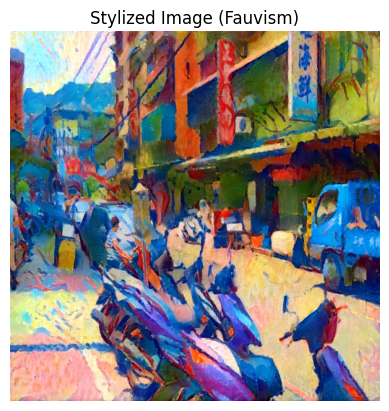

In [44]:
fauvism_output = style_transfer(content2, fauvism_style, vgg, steps=5000, stop_threshold=1000)
imshow(fauvism_output, "Stylized Image (Fauvism)")

Cubism

Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000002715.jpg


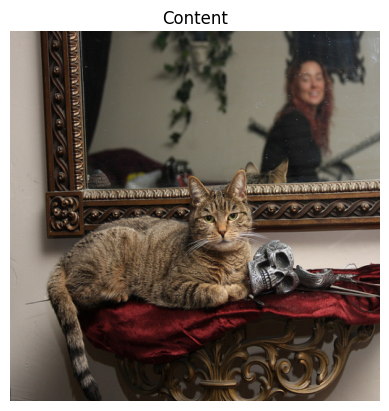

In [18]:
content_img3 = f"{COCO_PATH}/000000002715.jpg"
content3 = load_image(content_img3)
imshow(content3, "Content")
print("Content image:", content_img3)


Expressionism Style image: /content/drive/MyDrive/CMPE258/project/archive/Expressionism/edvard-munch_the-scream-1910.jpg


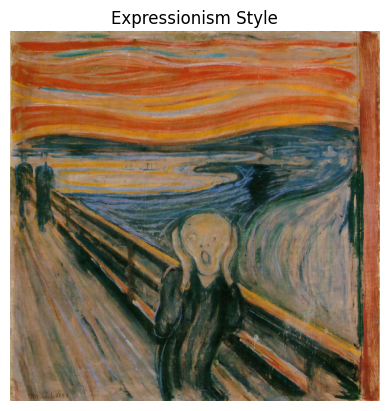

In [19]:
exp_style_img= f"{WIKIART_PATH}/Expressionism/edvard-munch_the-scream-1910.jpg"
exp_style = load_image(exp_style_img)
imshow(exp_style, "Expressionism Style")
print("Expressionism Style image:", exp_style_img)

Step [0/5000]  Total Loss: 8937495.00
Step [100/5000]  Total Loss: 564937.19
Step [200/5000]  Total Loss: 312596.69
Step [300/5000]  Total Loss: 214056.20
Step [400/5000]  Total Loss: 157222.27
Step [500/5000]  Total Loss: 120523.99
Step [600/5000]  Total Loss: 95998.51
Step [700/5000]  Total Loss: 79470.35
Step [800/5000]  Total Loss: 68180.25
Step [900/5000]  Total Loss: 60234.07
Step [1000/5000]  Total Loss: 54395.61
Step [1100/5000]  Total Loss: 49913.09
Step [1200/5000]  Total Loss: 46289.01
Step [1300/5000]  Total Loss: 43226.56
Step [1400/5000]  Total Loss: 40575.10
Step [1500/5000]  Total Loss: 38246.21
Step [1600/5000]  Total Loss: 36151.70
Step [1700/5000]  Total Loss: 34248.09
Step [1800/5000]  Total Loss: 32499.89
Step [1900/5000]  Total Loss: 30881.86
Step [2000/5000]  Total Loss: 29372.78
Step [2100/5000]  Total Loss: 27962.18
Step [2200/5000]  Total Loss: 26640.22
Step [2300/5000]  Total Loss: 25396.42
Step [2400/5000]  Total Loss: 24220.22
Step [2500/5000]  Total Loss: 

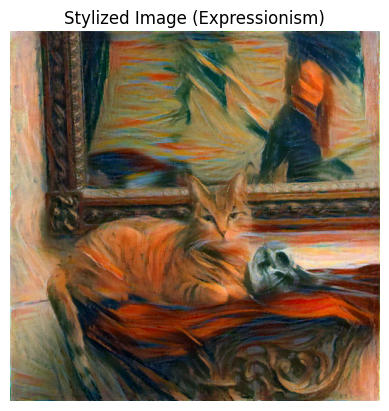

In [36]:
exp_output = style_transfer(content3, exp_style, vgg, steps=5000, stop_threshold=1000)
imshow(exp_output, "Stylized Image (Expressionism)")

In [52]:
print("Impressionism LPIPS: ", get_lpips(content1, impressionism_output))
print("Fauvism LPIPS: ", get_lpips(content2, fauvism_output))
print("Expressionism LPIPS: ", get_lpips(content3, exp_output))

Impressionism LPIPS:  0.5871378183364868
Fauvism LPIPS:  0.5550395846366882
Expressionism LPIPS:  0.554303765296936
